# Project 2 - LendingClub
## OPAN 6604 - Predictive Analytics
Mike Johnson - SAXA

****

## Set Up

In [1]:
# Import libraries

# Data Processing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn import svm

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load dataset
df = pd.read_csv('../data/raw/LC_HW2.csv')

df.head()

,all_util,annual_inc,application_type,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,emp_length,fico_range_high,fico_range_low,...,mo_sin_old_rev_tl_op,mort_acc,mths_since_last_record,mths_since_recent_inq,open_acc,pub_rec_bankruptcies,term,total_bal_ex_mort,verification_status,int_rate
0,80.0,36000.0,Individual,0,0,0,26.33,NaN,674,670,...,35,0,NaN,0.0,5,0,36 months,34683,Verified,18.62
1,61.0,45000.0,Individual,0,0,0,38.51,1 year,734,730,...,103,0,NaN,0.0,14,0,60 months,63873,Not Verified,16.08
2,31.0,53040.0,Individual,0,0,0,25.20,< 1 year,809,805,...,145,4,NaN,0.0,9,0,36 months,24452,Verified,7.56
3,87.0,125000.0,Individual,0,0,0,27.87,10+ years,684,680,...,230,4,NaN,19.0,14,0,36 months,141033,Verified,17.30
4,75.0,73000.0,Individual,0,0,0,35.12,10+ years,759,755,...,126,1,NaN,13.0,19,0,36 months,160302,Not Verified,10.81


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   all_util                    99984 non-null   float64
 1   annual_inc                  100000 non-null  float64
 2   application_type            100000 non-null  object 
 3   chargeoff_within_12_mths    100000 non-null  int64  
 4   collections_12_mths_ex_med  100000 non-null  int64  
 5   delinq_2yrs                 100000 non-null  int64  
 6   dti                         99814 non-null   float64
 7   emp_length                  91331 non-null   object 
 8   fico_range_high             100000 non-null  int64  
 9   fico_range_low              100000 non-null  int64  
 10  home_ownership              100000 non-null  object 
 11  inq_last_12m                100000 non-null  int64  
 12  loan_amnt                   100000 non-null  int64  
 13  mo_sin_old_il_a

### One Hot Encoding

Creating dummy variables for categorical variables. We'll save emp_length for later. This will be converted to numerical.

In [4]:
# Define categorical variables for one-hot encoding
cat_cols = ['application_type', 'home_ownership', 'term', 'verification_status']

# Initialize OneHotEncoder and drop the first dummy
ohe = OneHotEncoder(drop='first')

# Fit and transform the categorical column(s)
ohe_features = ohe.fit_transform(df[cat_cols]).toarray()

# Get the dummy column names from the encoder
ohe_labels = ohe.get_feature_names_out(cat_cols)

# Convert encoded output into a DataFrame
ohe_features = pd.DataFrame(ohe_features, columns=ohe_labels)

# Create a copy of the original DataFrame without the original categorical column(s)
df_nocat = df.drop(columns=cat_cols)

# Attach the dummy variable DataFrame to the rest of the dataset
df_encoded = pd.concat([df_nocat, ohe_features], axis=1)

# Final encoded dataset
df_encoded

,all_util,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,emp_length,fico_range_high,fico_range_low,inq_last_12m,...,mths_since_recent_inq,open_acc,pub_rec_bankruptcies,total_bal_ex_mort,int_rate,application_type_Joint App,home_ownership_OWN,home_ownership_RENT,term_ 60 months,verification_status_Verified
0,80.0,36000.0,0,0,0,26.33,NaN,674,670,5,...,0.0,5,0,34683,18.62,0.0,1.0,0.0,0.0,1.0
1,61.0,45000.0,0,0,0,38.51,1 year,734,730,1,...,0.0,14,0,63873,16.08,0.0,0.0,1.0,1.0,0.0
2,31.0,53040.0,0,0,0,25.20,< 1 year,809,805,1,...,0.0,9,0,24452,7.56,0.0,0.0,0.0,0.0,1.0
3,87.0,125000.0,0,0,0,27.87,10+ years,684,680,0,...,19.0,14,0,141033,17.30,0.0,0.0,0.0,0.0,1.0
4,75.0,73000.0,0,0,0,35.12,10+ years,759,755,0,...,13.0,19,0,160302,10.81,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,75.0,38500.0,0,0,0,51.75,2 years,664,660,1,...,6.0,17,0,45338,18.62,1.0,0.0,1.0,1.0,1.0
99996,59.0,165000.0,0,0,3,12.90,6 years,714,710,0,...,14.0,14,0,55842,8.19,0.0,0.0,0.0,0.0,0.0
99997,54.0,49999.0,0,0,0,32.67,< 1 year,664,660,0,...,NaN,14,0,36970,17.74,0.0,0.0,1.0,1.0,1.0
99998,54.0,62800.0,0,0,0,33.86,1 year,759,755,3,...,1.0,15,0,92636,8.19,0.0,0.0,0.0,1.0,1.0


****

## Train / Test Split

In [5]:
# Define features / target
X = df_encoded.drop(columns = ['int_rate']) # Features
y = df_encoded['int_rate'] # Target variable

# Hold back 25% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y,
                                                  test_size=0.25, # 25 % of TOTAL data
                                                  random_state=206)

# Split the remaining 75% into train and dev
X_train, X_dev, y_train, y_dev = train_test_split(X_temp, y_temp,
                                                  test_size=0.20, # 20 % of what's left... 15 % overall
                                                  random_state=206)

In [6]:
# Confirm shape of each set
print(f"Train: {X_train.shape}")
print(f"Dev: {X_dev.shape}")
print(f"Test: {X_test.shape}")

Train: (60000, 24)
Dev: (15000, 24)
Test: (25000, 24)


## Preprocessing

In [7]:
# Remove total_acc. Feature not present at loan origination
X_train = X_train.drop(columns = ['open_acc'])
X_dev = X_dev.drop(columns = ['open_acc'])
X_test = X_test.drop(columns = ['open_acc'])

### NA Handling

In [8]:
# Check for NA's
X_train.isna().sum()

all_util                           13
annual_inc                          0
chargeoff_within_12_mths            0
collections_12_mths_ex_med          0
delinq_2yrs                         0
dti                               119
emp_length                       5212
fico_range_high                     0
fico_range_low                      0
inq_last_12m                        0
loan_amnt                           0
mo_sin_old_il_acct               1349
mo_sin_old_rev_tl_op                0
mort_acc                            0
mths_since_last_record          54576
mths_since_recent_inq            6044
pub_rec_bankruptcies                0
total_bal_ex_mort                   0
application_type_Joint App          0
home_ownership_OWN                  0
home_ownership_RENT                 0
term_ 60 months                     0
verification_status_Verified        0
dtype: int64

#### all_util

Represents the balance to credit limit on all trades. This can be measured by the following equation:


$$all\_util = 100 \times \frac{\text{total balance on all accounts}}{\text{total credit-limit on accounts}}$$


An NA would likely mean that applicant does not have any trades with a positive credit-limit, leading to a denomincator of 0. This means that applicant likely has no open credit-limit lines, so their utilization ratio is 0%.

For this column, 0 will be imputed for any NA's.

In [9]:
# Imput 0 for NA's in all_util
X_train['all_util'] = X_train['all_util'].fillna(0) # Apply to training set
X_dev['all_util'] = X_dev['all_util'].fillna(0) # Apply to training set
X_test['all_util'] = X_test['all_util'].fillna(0) # Apply to test set

# Confirm NA's handled
print(f"NA count in training set: {X_train['all_util'].isna().sum()}")
print(f"NA count in dev set: {X_dev['all_util'].isna().sum()}")
print(f"NA count in test set: {X_test['all_util'].isna().sum()}")

NA count in training set: 0
NA count in dev set: 0
NA count in test set: 0


### dti

A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income. 

$$dti = 100 \times \frac{\text{total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan}}{\text{borrower’s self-reported monthly income}}$$

An NA likely means that the applicant had no income and is reflected in the training set. Imputing 0 is implies an exceptional DTI, but no income suggests a credit risk. On the other hand, imputing 999 to represent these missing values might mislead the training of the model. 

Instead, median dti will be imputed and a dummy variable that flags missing values in the dti so that the model can learn whether DTI carries information.

In [10]:
# Confirm NA's in dti also have an annual income of 0. The training set largely has annual incomes of 0 with a max value of 2.
X_train.loc[X_train['dti'].isna(), 'annual_inc'].describe()

count    119.000000
mean       0.016807
std        0.183340
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: annual_inc, dtype: float64

In [11]:
# Run stats of DTI. Data is skewed right. Impute the median for NAs
X_train['dti'].describe()

count    59881.000000
mean        21.583338
std         19.221776
min          0.000000
25%         13.400000
50%         19.730000
75%         26.960000
max        999.000000
Name: dti, dtype: float64

In [12]:
# Add conditional column that identifies applicants with NA DTI
X_train['dti_missing'] = X_train['dti'].isna().astype(int)
X_dev['dti_missing'] = X_dev['dti'].isna().astype(int)
X_test['dti_missing'] = X_test['dti'].isna().astype(int)

In [13]:
# Impute median for NA's in DTI.
dti_median = X_train['dti'].median()
X_train['dti'] = X_train['dti'].fillna(dti_median) # Apply to training set
X_dev['dti'] = X_dev['dti'].fillna(dti_median) # Apply to dev set
X_test['dti'] = X_test['dti'].fillna(dti_median) # Apply to test set

# Confirm NA's handled
print(f"NA count in training set: {X_train['dti'].isna().sum()}")
print(f"NA count in dev set: {X_dev['dti'].isna().sum()}")
print(f"NA count in test set: {X_test['dti'].isna().sum()}")

NA count in training set: 0
NA count in dev set: 0
NA count in test set: 0


### emp_length

Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

NA's likely represent cases where the applicant did not provide their data related to the feature. To handle NA's, the feature will be converted to an integer, impute the median, and add a dummy variable that identifies a missing emp_length.

In [14]:
# Convert emp_length to numeric

# Define order of ordinal values
emp_length_order = ['< 1 year','1 year','2 years','3 years','4 years','5 years','6 years','7 years','8 years','9 years','10+ years']

# Convert to an *ordered* categorical, then grab the integer codes
X_train['emp_length_num'] = pd.Categorical(X_train['emp_length'],
                                           categories = emp_length_order,
                                           ordered = True).codes

X_dev['emp_length_num'] = pd.Categorical(X_dev['emp_length'],
                                           categories = emp_length_order,
                                           ordered = True).codes

X_test['emp_length_num'] = pd.Categorical(X_test['emp_length'],
                                          categories = emp_length_order,
                                          ordered = True).codes

# -1 = NaN/missing -> replace with actual NaN
X_train.loc[X_train['emp_length_num'] == -1, 'emp_length_num'] = np.nan
X_dev.loc[X_dev['emp_length_num'] == -1, 'emp_length_num'] = np.nan
X_test.loc[X_test['emp_length_num'] == -1, 'emp_length_num'] = np.nan

In [15]:
# Drop emp_length
X_train = X_train.drop(columns='emp_length')
X_dev = X_dev.drop(columns='emp_length')
X_test = X_test.drop(columns='emp_length')

In [16]:
# Run stats of emp_lenth_num. Impute the median for NAs
X_train['emp_length_num'].describe()

count    54788.000000
mean         5.315306
std          3.839950
min          0.000000
25%          2.000000
50%          5.000000
75%         10.000000
max         10.000000
Name: emp_length_num, dtype: float64

In [17]:
# Add conditional column that identifies applicants with NA emp_length_num
X_train['emp_length_missing'] = X_train['emp_length_num'].isna().astype(int)
X_dev['emp_length_missing'] = X_dev['emp_length_num'].isna().astype(int)
X_test['emp_length_missing'] = X_test['emp_length_num'].isna().astype(int)

In [18]:
# Impute median for NA's in emp_length_num.
emp_length_median = X_train['emp_length_num'].median()
X_train['emp_length_num'] = X_train['emp_length_num'].fillna(emp_length_median) # Apply to training set
X_dev['emp_length_num'] = X_dev['emp_length_num'].fillna(emp_length_median) # Apply to training set
X_test['emp_length_num'] = X_test['emp_length_num'].fillna(emp_length_median) # Apply to test set

# Confirm NA's handled
print(f"NA count in training set: {X_train['emp_length_num'].isna().sum()}")
print(f"NA count in training set: {X_dev['emp_length_num'].isna().sum()}")
print(f"NA count in test set: {X_test['emp_length_num'].isna().sum()}")

NA count in training set: 0
NA count in training set: 0
NA count in test set: 0


### mo_sin_old_il_acct

Months since oldest bank installment account opened. NA's likely represent cases where the applicant has no installment account.

In these cases, 0 will be imputed and a dummy variable will be added to flag instances where there are no installment accounts.

In [19]:
# Add conditional column that identifies applicants with NA mo_sin_old_il_acct.
X_train['mo_sin_old_il_acct_missing'] = X_train['mo_sin_old_il_acct'].isna().astype(int)
X_dev['mo_sin_old_il_acct_missing'] = X_dev['mo_sin_old_il_acct'].isna().astype(int)
X_test['mo_sin_old_il_acct_missing'] = X_test['mo_sin_old_il_acct'].isna().astype(int)

In [20]:
# Imput 0 for NA's in all_util
X_train['mo_sin_old_il_acct'] = X_train['mo_sin_old_il_acct'].fillna(0) # Apply to training set
X_dev['mo_sin_old_il_acct'] = X_dev['mo_sin_old_il_acct'].fillna(0) # Apply to dev set
X_test['mo_sin_old_il_acct'] = X_test['mo_sin_old_il_acct'].fillna(0) # Apply to test set

# Confirm NA's handled
print(f"NA count in training set: {X_train['mo_sin_old_il_acct'].isna().sum()}")
print(f"NA count in training set: {X_dev['mo_sin_old_il_acct'].isna().sum()}")
print(f"NA count in test set: {X_test['mo_sin_old_il_acct'].isna().sum()}")

NA count in training set: 0
NA count in training set: 0
NA count in test set: 0


### mths_since_last_record

The number of months since the last public record. There are a lot of NA's (90% in the training set).

This column will be dropped since there's isn't enough data to work with.

In [21]:
# Percent of values missing
X_train['mths_since_last_record'].isna().sum() / len(X_train)

0.9096

In [22]:
# Drop emp_length
X_train = X_train.drop(columns = 'mths_since_last_record')
X_dev = X_dev.drop(columns = 'mths_since_last_record')
X_test = X_test.drop(columns = 'mths_since_last_record')

### mths_since_recent_inq

Months since most recent inquiry. NA's likely mean that there are no inquiries on file for the applicant.

NA's will be imputed with 0 and add a dummy variable that flags the NA's.

In [23]:
# Add conditional column that identifies applicants with NA DTI
X_train['mths_since_recent_inq_missing'] = X_train['mths_since_recent_inq'].isna().astype(int)
X_dev['mths_since_recent_inq_missing'] = X_dev['mths_since_recent_inq'].isna().astype(int)
X_test['mths_since_recent_inq_missing'] = X_test['mths_since_recent_inq'].isna().astype(int)

In [24]:
# Imput 0 for NA's in all_util
X_train['mths_since_recent_inq'] = X_train['mths_since_recent_inq'].fillna(0) # Apply to training set
X_dev['mths_since_recent_inq'] = X_dev['mths_since_recent_inq'].fillna(0) # Apply to dev set
X_test['mths_since_recent_inq'] = X_test['mths_since_recent_inq'].fillna(0) # Apply to test set

# Confirm NA's handled
print(f"NA count in training set: {X_train['mths_since_recent_inq'].isna().sum()}")
print(f"NA count in training set: {X_dev['mths_since_recent_inq'].isna().sum()}")
print(f"NA count in test set: {X_test['mths_since_recent_inq'].isna().sum()}")

NA count in training set: 0
NA count in training set: 0
NA count in test set: 0


## Outlier Detection and Handling

In [25]:
X_train.describe()

,all_util,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,fico_range_high,fico_range_low,inq_last_12m,loan_amnt,...,application_type_Joint App,home_ownership_OWN,home_ownership_RENT,term_ 60 months,verification_status_Verified,dti_missing,emp_length_num,emp_length_missing,mo_sin_old_il_acct_missing,mths_since_recent_inq_missing
count,60000.000000,6.000000e+04,60000.000000,60000.000000,60000.0000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,55.003417,8.841300e+04,0.005917,0.015500,0.2163,21.579662,710.657200,706.657000,2.054067,16818.732917,...,0.127450,0.118150,0.401550,0.345150,0.468717,0.001983,5.287917,0.086867,0.022483,0.100733
std,20.164651,9.351984e+04,0.086111,0.140214,0.7125,19.202882,35.663547,35.662768,2.310844,10429.386119,...,0.333479,0.322788,0.490216,0.475421,0.499025,0.044491,3.670451,0.281642,0.148250,0.300978
min,0.000000,0.000000e+00,0.000000,0.000000,0.0000,0.000000,664.000000,660.000000,0.000000,1000.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.000000,5.000000e+04,0.000000,0.000000,0.0000,13.410000,684.000000,680.000000,0.000000,8500.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,55.000000,7.299150e+04,0.000000,0.000000,0.0000,19.730000,704.000000,700.000000,1.000000,15000.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000
75%,69.000000,1.050000e+05,0.000000,0.000000,0.0000,26.940000,729.000000,725.000000,3.000000,24000.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,10.000000,0.000000,0.000000,0.000000
max,185.000000,8.645185e+06,6.000000,10.000000,19.0000,999.000000,850.000000,845.000000,40.000000,40000.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,1.000000,1.000000,1.000000


### all_util

Instances greater than 100% are rare and create noise. Instances > 100% will be removed.

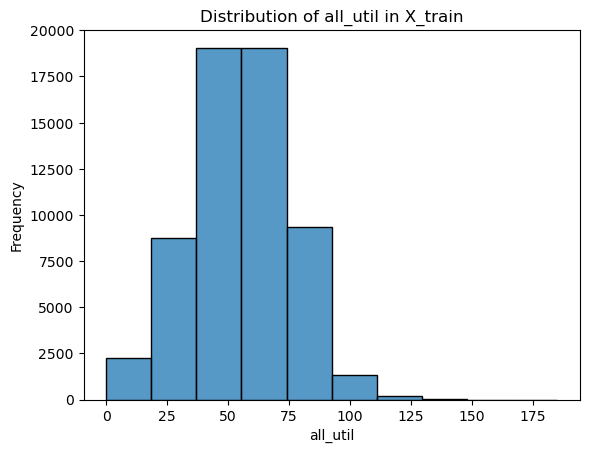

In [26]:
# Visualize distribution of all_util
sns.histplot(X_train['all_util'], bins = 10)

# Add labels and title
plt.title('Distribution of all_util in X_train')
plt.xlabel('all_util')
plt.ylabel('Frequency')

plt.show()

In [27]:
# Remove instances all_util > 100
X_train = X_train[X_train['all_util'] <= 100]

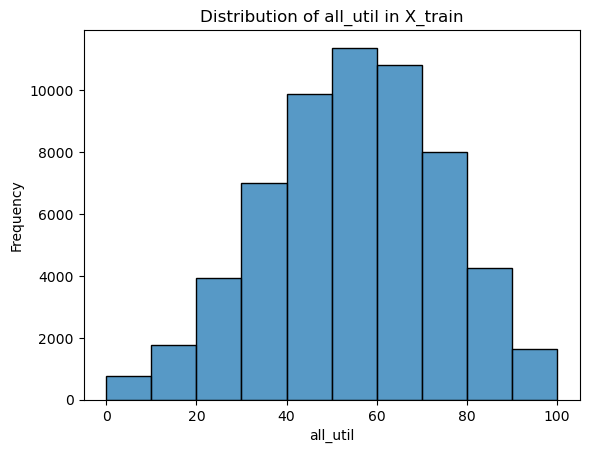

In [28]:
# Confirm that instances were removed.

# Visualize distribution of all_util
sns.histplot(X_train['all_util'], bins = 10)

# Add labels and title
plt.title('Distribution of all_util in X_train')
plt.xlabel('all_util')
plt.ylabel('Frequency')

plt.show()

### chargeoff_within_12_mths

Most applicants have no chargeoffs in the past 12 months. Instead, it would makse sense to convert this feature to a binary that measures if the applicant had a chargeoff in the last 12 months. This should be enough signal for the model.

In [29]:
# Group by chargeoff_within_12_mths
X_train.groupby('chargeoff_within_12_mths').size()

chargeoff_within_12_mths
0    59084
1      299
2       16
3        3
4        1
6        1
dtype: int64

In [30]:
# Most applicants do not have chargeoffs on record.
# Makes sense to convert ot a binary that measures if the applicant had a chargeoff if the last 12 months.
X_train['chargeoff_within_12_mths'] = np.where(X_train['chargeoff_within_12_mths'] > 0, 1, 0)
X_test['chargeoff_within_12_mths'] = np.where(X_test['chargeoff_within_12_mths'] > 0, 1, 0)

### collections_12_mths_ex_med

Similar case where most applicants have no chargeoffs (excluding medical) in the past 12 months. Instead, it would makse sense to convert this feature to a binary that measures if the applicant had a chargeoff in the last 12 months. This should be enough signal for the model.

In [31]:
# Group by collections_12_mths_ex_med
X_train.groupby('collections_12_mths_ex_med').size()

collections_12_mths_ex_med
0     58564
1       783
2        47
3         8
6         1
10        1
dtype: int64

In [32]:
# Most applicants do not have collections on record.
# Makes sense to convert ot a binary that measures if the applicant had a collections if the last 12 months.
X_train['collections_12_mths_ex_med'] = np.where(X_train['collections_12_mths_ex_med'] > 0, 1, 0)
X_test['collections_12_mths_ex_med'] = np.where(X_test['collections_12_mths_ex_med'] > 0, 1, 0)

### delinq_2yrs

Most applicants do not have delinquencies on their record. Like previous the previous two features, this will be converted to binary. This should be enough signal for the model.

In [33]:
# Group by delinq_2yrs
X_train.groupby('delinq_2yrs').size()

delinq_2yrs
0     51164
1      5893
2      1361
3       508
4       216
5       107
6        59
7        37
8        23
9        12
10       10
11        6
12        3
13        2
14        1
15        1
17        1
dtype: int64

In [34]:
# Most applicants do not have delinquencies on record.
# Makes sense to convert ot a binary that measures if the applicant had a delinquencies if the last 2 years.
X_train['delinq_2yrs'] = np.where(X_train['delinq_2yrs'] > 0, 1, 0)
X_test['delinq_2yrs'] = np.where(X_test['delinq_2yrs'] > 0, 1, 0)

### annual_inc

Annual income is skewed right some extreme values. Even when removing instances > 99th percentile, it's still skewed right. A transformation will be applied to give annual income a normal distribution.

Any instances > 99th percentile will removed and square root transformation will be applied to the data that remains.

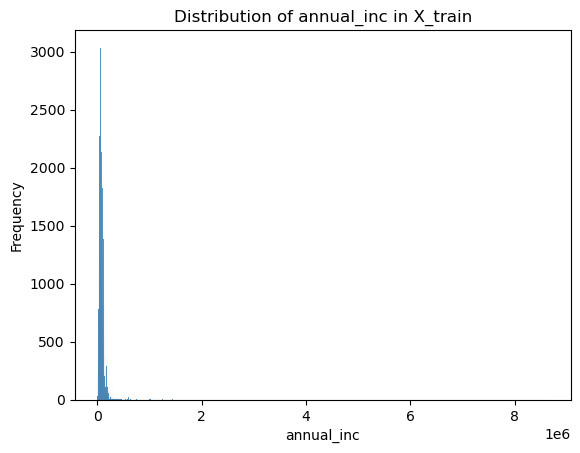

In [35]:
# Visualize distribution of annual_inc
sns.histplot(X_train['annual_inc'])

# Add labels and title
plt.title('Distribution of annual_inc in X_train')
plt.xlabel('annual_inc')
plt.ylabel('Frequency')

plt.show()

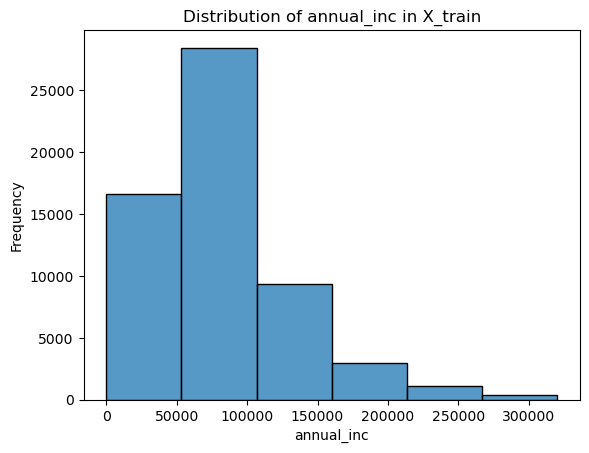

In [36]:
# Long tail. Let's zoom in to just the 99th percentile

# Visualize distribution of annual_inc
sns.histplot(X_train.loc[X_train['annual_inc'] <= X_train['annual_inc'].quantile(0.99) ,'annual_inc'], binwidth = 50000)

# Add labels and title
plt.title('Distribution of annual_inc in X_train')
plt.xlabel('annual_inc')
plt.ylabel('Frequency')

plt.show()

In [37]:
# Looks better so let's remove the points > 99th percentile
X_train = X_train[X_train['annual_inc'] <= X_train['annual_inc'].quantile(0.99)]

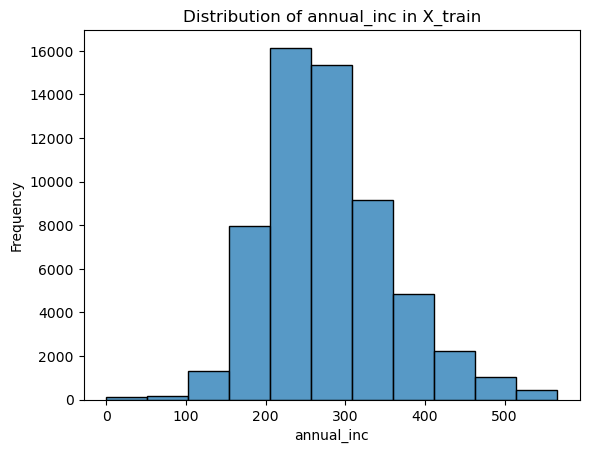

In [38]:
# Since the data is still skewed right, let's explore a square root tranformation.

# Visualize distribution of annual_inc
sns.histplot(np.sqrt(X_train['annual_inc']), binwidth=50)

# Add labels and title
plt.title('Distribution of annual_inc in X_train')
plt.xlabel('annual_inc')
plt.ylabel('Frequency')

plt.show()

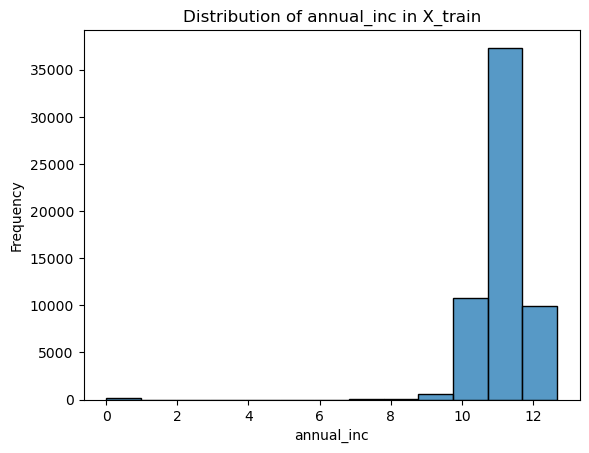

In [39]:
# Let's explore a log transformation

# Visualize distribution of annual_inc
sns.histplot(np.log(X_train['annual_inc']+1), binwidth = 1)

# Add labels and title
plt.title('Distribution of annual_inc in X_train')
plt.xlabel('annual_inc')
plt.ylabel('Frequency')

plt.show()

In [40]:
# Apply a square root transformation to annual income
X_train['annual_inc_sqrt'] = np.sqrt(X_train['annual_inc'])
X_dev['annual_inc_sqrt'] = np.sqrt(X_dev['annual_inc'])
X_test['annual_inc_sqrt'] = np.sqrt(X_test['annual_inc'])

# Drop original columns
X_train = X_train.drop(columns = ['annual_inc'])
X_dev = X_dev.drop(columns = ['annual_inc'])
X_test = X_test.drop(columns = ['annual_inc'])

### dti

Another case of a feature with a long tail. Even when filtering to the 99th percentile, there's still a tail at roughly 40%. As a result, data > 40% will be removed.

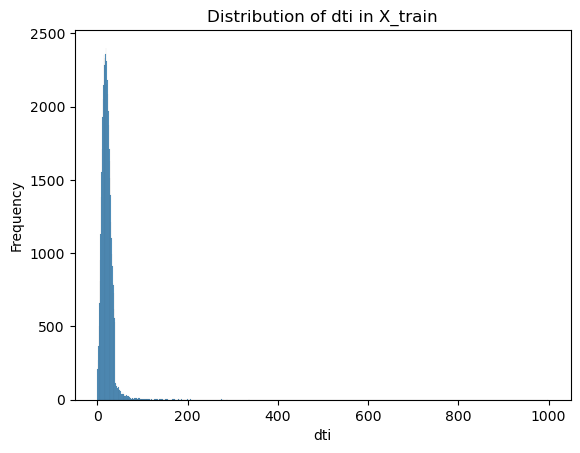

In [41]:
# Visualize distribution of all_util
sns.histplot(X_train['dti'], binwidth = 1)

# Add labels and title
plt.title('Distribution of dti in X_train')
plt.xlabel('dti')
plt.ylabel('Frequency')

plt.show()

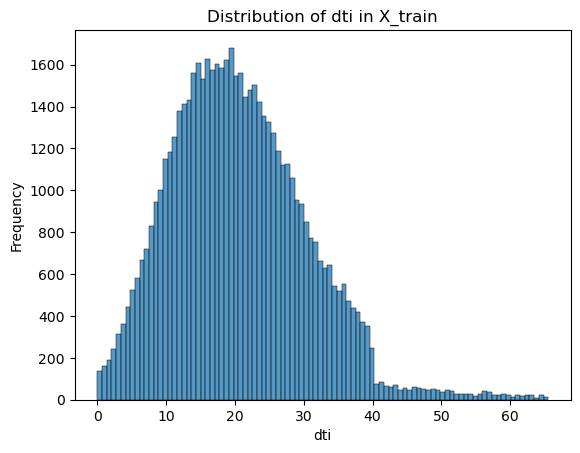

In [42]:
# Long tail. Let's zoom in to just the 99th percentile. Data drops off at ~40.

# Visualize distribution of dti
sns.histplot(X_train.loc[X_train['dti'] <= X_train['dti'].quantile(0.99) ,'dti'])

# Add labels and title
plt.title('Distribution of dti in X_train')
plt.xlabel('dti')
plt.ylabel('Frequency')

plt.show()

In [43]:
# Instances > 40 will be removed
X_train = X_train[X_train['dti'] <= 40]

### Fico

The descriptive statistics suggest that all fico_range_low and fico_range_high scores have a range of 4. After verifying, this is true. Dropping fico_range_low since fico_range_high will suffice.

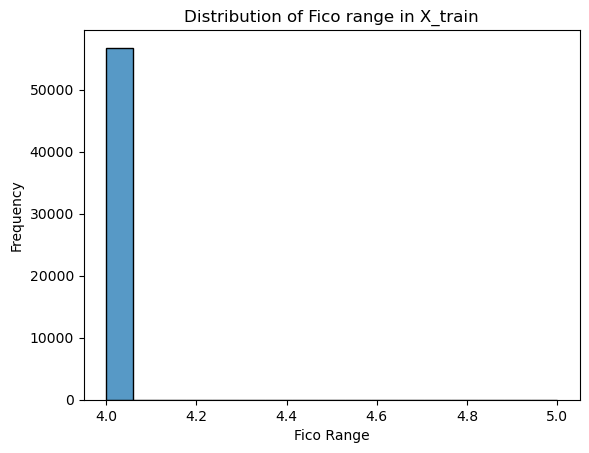

In [44]:
# Data preview suggest there's a consistent difference between the high and low score. Let's verify.
sns.histplot(X_train['fico_range_high'] - X_train['fico_range_low'])

# Add labels and title
plt.title('Distribution of Fico range in X_train')
plt.xlabel('Fico Range')
plt.ylabel('Frequency')

plt.show()

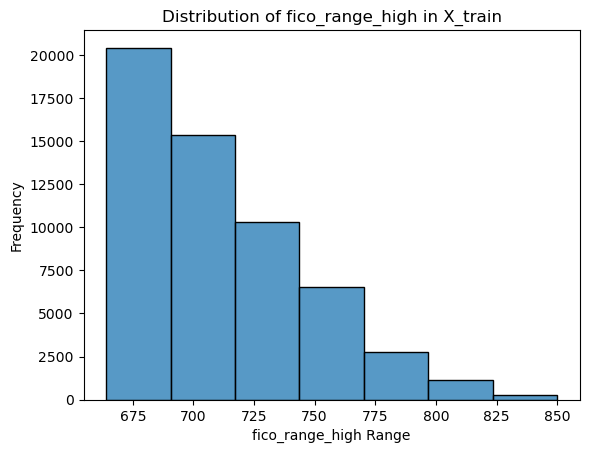

In [45]:
# Data preview suggest there's a consistent difference between the high and low score. Let's verify.
sns.histplot(X_train['fico_range_high'], binwidth = 25)

# Add labels and title
plt.title('Distribution of fico_range_high in X_train')
plt.xlabel('fico_range_high Range')
plt.ylabel('Frequency')

plt.show()

In [46]:
# It's all 4. Dropping the low column
X_train = X_train.drop(columns = ['fico_range_low'])
X_dev = X_dev.drop(columns = ['fico_range_low'])
X_test = X_test.drop(columns = ['fico_range_low'])

### inq_last_12m

Another long tail. Removing data > the 99th percentile.

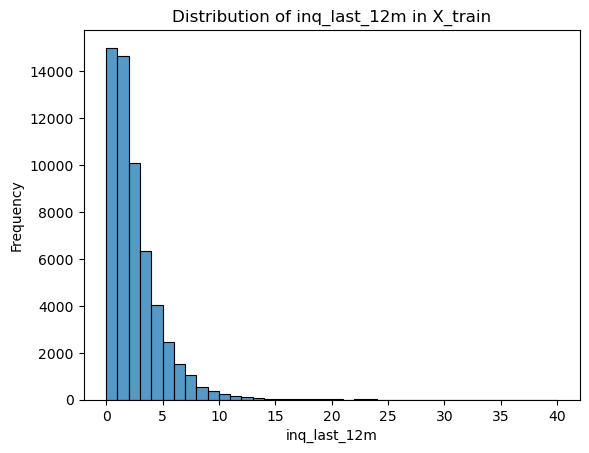

In [47]:
# Visualize distribution of inq_last_12m
sns.histplot(X_train['inq_last_12m'], binwidth = 1)

# Add labels and title
plt.title('Distribution of inq_last_12m in X_train')
plt.xlabel('inq_last_12m')
plt.ylabel('Frequency')

plt.show()

In [48]:
# 99% captured at 10.
X_train['inq_last_12m'].quantile(0.99)

10.0

In [49]:
# Remove instances where inquiries are greater than 10
X_train = X_train[X_train['inq_last_12m'] <= 10]

### mo_sin_old_il_acct

Another long tail. Removing instances that are greater than the 99th percentile.

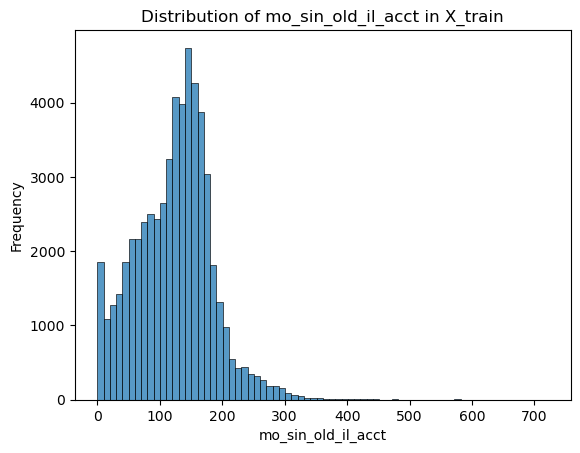

In [50]:
# Visualize distribution of mo_sin_old_il_acct
sns.histplot(X_train['mo_sin_old_il_acct'], binwidth = 10)

# Add labels and title
plt.title('Distribution of mo_sin_old_il_acct in X_train')
plt.xlabel('mo_sin_old_il_acct')
plt.ylabel('Frequency')

plt.show()

In [51]:
# 99% captured at 287.
X_train['mo_sin_old_il_acct'].quantile(0.99)

287.0

In [52]:
# Remove instances where inquiries are greater than 287
X_train = X_train[X_train['mo_sin_old_il_acct'] <= 287]

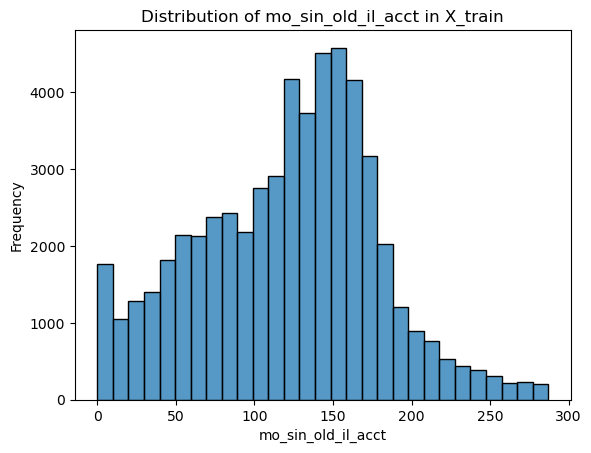

In [53]:
# Visualize distribution of mo_sin_old_il_acct
sns.histplot(X_train['mo_sin_old_il_acct'], binwidth = 10)

# Add labels and title
plt.title('Distribution of mo_sin_old_il_acct in X_train')
plt.xlabel('mo_sin_old_il_acct')
plt.ylabel('Frequency')

plt.show()

### mo_sin_old_rev_tl_op

Another long tail. Removing instances > than the 99th percentile.

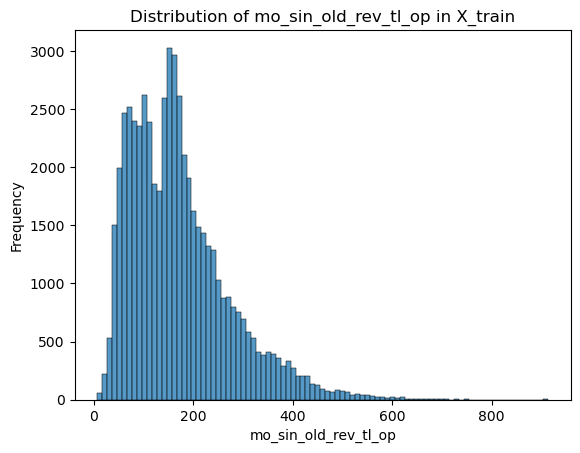

In [54]:
# Visualize distribution of mo_sin_old_rev_tl_op
sns.histplot(X_train['mo_sin_old_rev_tl_op'], binwidth = 10)

# Add labels and title
plt.title('Distribution of mo_sin_old_rev_tl_op in X_train')
plt.xlabel('mo_sin_old_rev_tl_op')
plt.ylabel('Frequency')

plt.show()

In [55]:
# 99% captured at 287.
X_train['mo_sin_old_rev_tl_op'].quantile(0.99)

486.8799999999974

In [56]:
# Remove instances where inquiries are greater than 287
X_train = X_train[X_train['mo_sin_old_rev_tl_op'] <= 485]

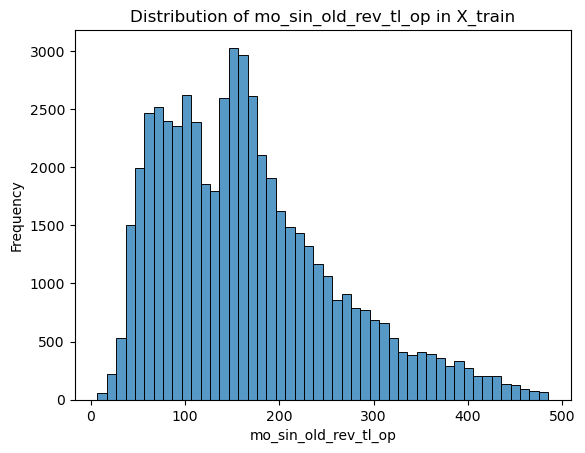

In [57]:
# Visualize distribution of mo_sin_old_rev_tl_op
sns.histplot(X_train['mo_sin_old_rev_tl_op'], binwidth = 10)

# Add labels and title
plt.title('Distribution of mo_sin_old_rev_tl_op in X_train')
plt.xlabel('mo_sin_old_rev_tl_op')
plt.ylabel('Frequency')

plt.show()

### mort_acc

Another long tail. Removing instances greater than the 99th percentile. Also, many applicants don't have a mortgage account. Adding a binary column to identify those who do and do not assist with training.

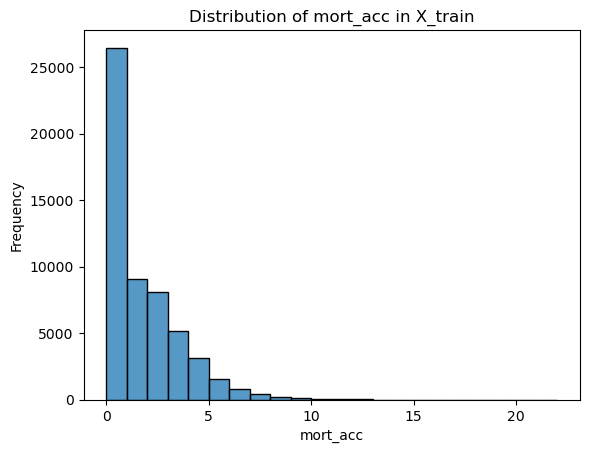

In [58]:
# Visualize distribution of mo_sin_old_rev_tl_op
sns.histplot(X_train['mort_acc'], binwidth = 1)

# Add labels and title
plt.title('Distribution of mort_acc in X_train')
plt.xlabel('mort_acc')
plt.ylabel('Frequency')

plt.show()

In [59]:
# 99% captured at 7.
X_train['mort_acc'].quantile(0.99)

7.0

In [60]:
# Remove instances > 7
X_train = X_train[X_train['mort_acc'] <= 7]

# Add a binary column that evaluates if the applicant had mortgage account.
X_train['has_mort_acc'] = np.where(X_train['mort_acc'] > 0, 1, 0)
X_dev['has_mort_acc'] = np.where(X_dev['mort_acc'] > 0, 1, 0)
X_test['has_mort_acc'] = np.where(X_test['mort_acc'] > 0, 1, 0)

### mths_since_recent_inq

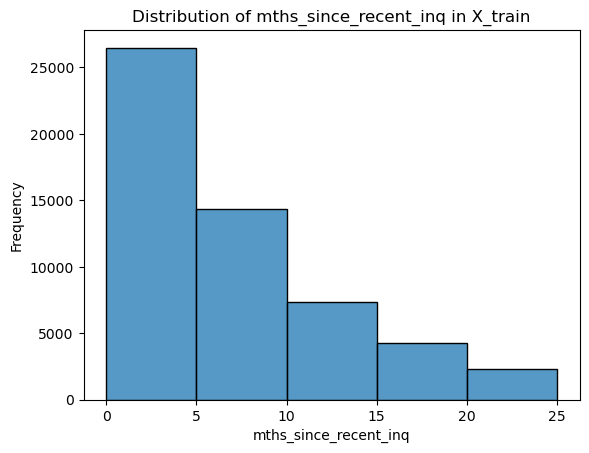

In [61]:
# Visualize distribution of mo_sin_old_rev_tl_op
sns.histplot(X_train['mths_since_recent_inq'], binwidth = 5)

# Add labels and title
plt.title('Distribution of mths_since_recent_inq in X_train')
plt.xlabel('mths_since_recent_inq')
plt.ylabel('Frequency')

plt.show()

### pub_rec_bankruptcies

Many applicants do not have bankruptcies on their record. Converting to a binary that measures whether or not the applicant had one. 

In [62]:
# Group by chargeoff_within_12_mths
X_train.groupby('pub_rec_bankruptcies').size()

pub_rec_bankruptcies
0    49780
1     4908
2       58
3        5
4        3
7        1
dtype: int64

In [63]:
# Most applicants do not have bankruptcies on record.
# Makes sense to convert ot a binary that measures if the applicant had a bankruptcy.
X_train['pub_rec_bankruptcies'] = np.where(X_train['pub_rec_bankruptcies'] > 0, 1, 0)
X_dev['pub_rec_bankruptcies'] = np.where(X_dev['pub_rec_bankruptcies'] > 0, 1, 0)
X_test['pub_rec_bankruptcies'] = np.where(X_test['pub_rec_bankruptcies'] > 0, 1, 0)

### total_bal_ex_mort

Long tail. Removing instances greater than the 99th percentile. Also added a square root transformation to to give it a normal distribution.

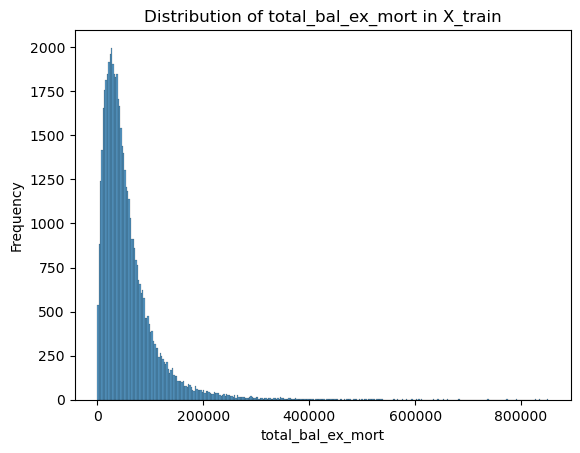

In [64]:
# Visualize distribution of total_bal_ex_mort
sns.histplot(X_train['total_bal_ex_mort'])

# Add labels and title
plt.title('Distribution of total_bal_ex_mort in X_train')
plt.xlabel('total_bal_ex_mort')
plt.ylabel('Frequency')

plt.show()

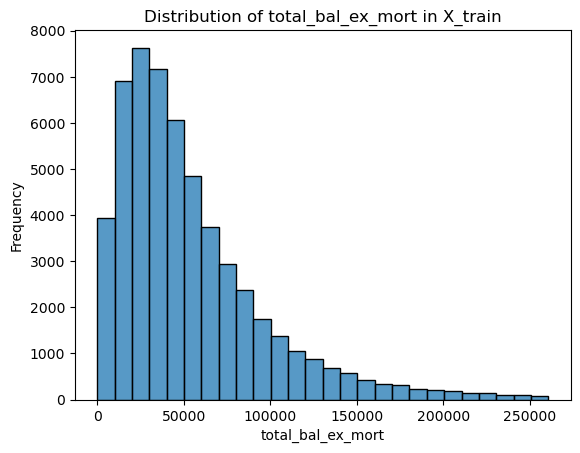

In [65]:
# Long tail. Let's zoom in to just the 99th percentile

# Visualize distribution of annual_inc
sns.histplot(X_train.loc[X_train['total_bal_ex_mort'] <= X_train['total_bal_ex_mort'].quantile(0.99) ,'total_bal_ex_mort'], binwidth = 10000)

# Add labels and title
plt.title('Distribution of total_bal_ex_mort in X_train')
plt.xlabel('total_bal_ex_mort')
plt.ylabel('Frequency')

plt.show()

In [66]:
# Looks better so let's remove the points > 99th percentile
X_train = X_train[X_train['total_bal_ex_mort'] <= X_train['total_bal_ex_mort'].quantile(0.99)]

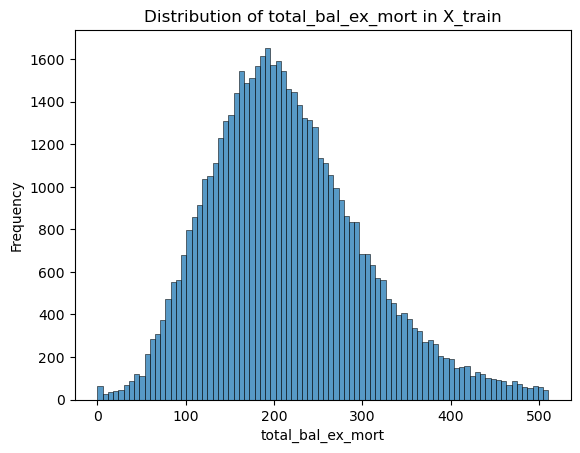

In [67]:
# Since the data is still skewed right, let's explore a square root tranformation.

# Visualize distribution of total_bal_ex_mort
sns.histplot(np.sqrt(X_train['total_bal_ex_mort']))

# Add labels and title
plt.title('Distribution of total_bal_ex_mort in X_train')
plt.xlabel('total_bal_ex_mort')
plt.ylabel('Frequency')

plt.show()

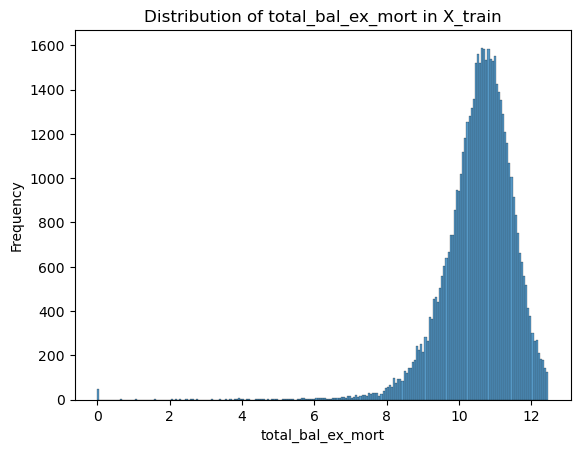

In [68]:
# Since the data is still skewed right, let's explore a log tranformation.

# Visualize distribution of total_bal_ex_mort
sns.histplot(np.log(X_train['total_bal_ex_mort']+1))

# Add labels and title
plt.title('Distribution of total_bal_ex_mort in X_train')
plt.xlabel('total_bal_ex_mort')
plt.ylabel('Frequency')

plt.show()

In [69]:
# Apply a square root transformation to annual income
X_train['total_bal_ex_mort_sqrt'] = np.sqrt(X_train['total_bal_ex_mort'])
X_dev['total_bal_ex_mort_sqrt'] = np.sqrt(X_dev['total_bal_ex_mort'])
X_test['total_bal_ex_mort_sqrt'] = np.sqrt(X_test['total_bal_ex_mort'])

# Drop original columns
X_train = X_train.drop(columns = ['total_bal_ex_mort'])
X_dev = X_dev.drop(columns = ['total_bal_ex_mort'])
X_test = X_test.drop(columns = ['total_bal_ex_mort'])

### Apply preprocessing to y_train

In [70]:
y_train = y_train.loc[X_train.index]

In [71]:
print(X_train.shape)
print(y_train.shape)

(54207, 26)
(54207,)


****

## Data Exploration

In [73]:
# Create df using training set for EDA
df_eda = X_train
df_eda['int_rate'] = y_train